In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera
from sionna.rt.utils import r_hat
from sionna.ofdm import ResourceGrid
from sionna.channel.utils import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.constants import SPEED_OF_LIGHT

In [74]:
scene = load_scene("../models/wireless insite/insite.xml")

# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso","V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [ 7.25, 2, 1]))
scene.add(Receiver("rx",    [ 0.6, 2, 1]))

# Compute paths
# paths = scene.compute_paths(max_depth=1)
# paths.normalize_delays = False # Do not normalize the delays such that the first path arrives at tau=0

scene.frequency = 9.2e10
scene.synthetic_array = True
paths = scene.compute_paths(max_depth=5, 
                            num_samples=1e6)
scene.preview(paths, show_devices=True, show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

[0.00000000e+00 5.60387647e-09 3.70361519e-09 4.00276967e-09
 1.72124732e-08 1.95974881e-08 9.60664259e-09 2.37882123e-08
 3.18202069e-08 7.20619475e-09 3.52380169e-08 5.21405710e-08
 6.56639116e-08 6.35773105e-08 5.97344894e-08 6.08928943e-08
 4.59732874e-08 6.44558256e-08 1.07941354e-07 5.79734447e-08
 5.95745391e-08 5.39706733e-08 1.63908123e-08 3.33431416e-08
 1.90797547e-08 1.64988432e-08 1.26626620e-08 1.21505561e-08
 5.68448399e-08 3.33327961e-08 4.71937085e-08 4.80812261e-08
 5.85136135e-08 6.96894489e-08 4.07047338e-08 1.11944097e-07
 1.13545219e-07 1.13668328e-07 4.73790962e-08]
[-0.0000000e+00 -0.0000000e+00 -3.1027065e+01 -1.8000002e+02
 -5.5731350e+01 -1.2880983e+02 -1.8000002e+02 -1.3491180e+02
 -5.8204700e+01 -1.5299870e+02  1.1713073e+02  2.5978546e+01
 -8.7362347e+00 -1.8000000e+02 -1.7062590e+02  1.6662778e+02
  7.1006393e+01 -2.1596590e+01 -3.6476313e-06 -1.8000000e+02
 -1.8238156e-06 -1.8238156e-06 -1.5976291e+02  6.6453400e+01
  1.2939044e+02  5.5007984e+01 -2.2514

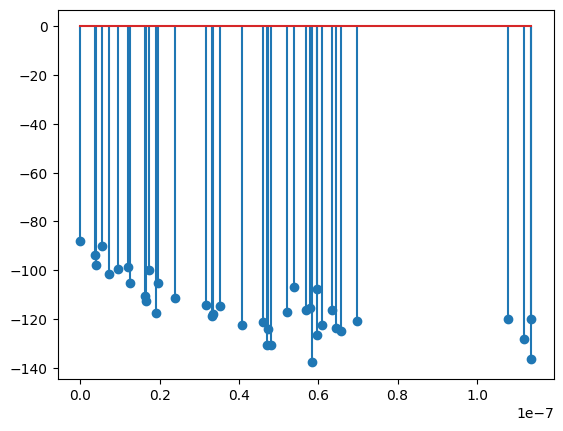

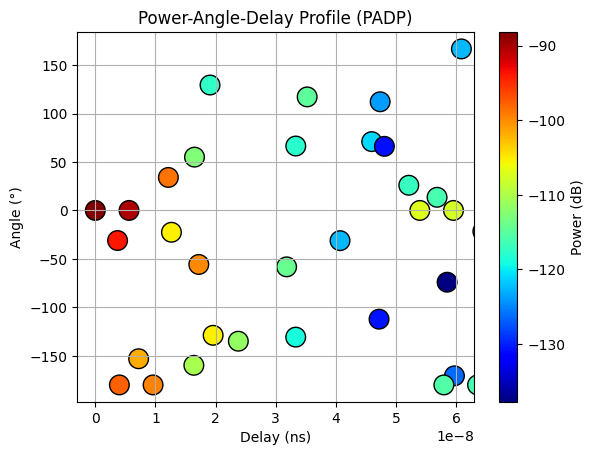

In [76]:
# tau表示每个信道的时延
print(paths.tau.numpy().squeeze())
print(paths.phi_r.numpy().squeeze() * 180 / 3.1415926)
print(paths.tau.numpy().squeeze() * 3e8)
# print(paths.a.numpy().squeeze())
# a表示信道系数，a的幅值的平方表示接收信号的能量
# print(np.abs(paths.a.numpy().squeeze())**2)
# 用分贝形式表示
print(10 * np.log10(np.abs(paths.a.numpy().squeeze())**2))
# 每个物体经过的路径
# 0 - 木头门 | 1 - 玻璃窗 | 2 - 金属 | 3 - 墙面
# print(paths.objects.numpy().squeeze())

# plt.figure()
# plt.stem(paths.tau.numpy().squeeze(), 10 * np.log10(np.abs(paths.a.numpy().squeeze())**2))
plt.figure()
plt.scatter(paths.tau.numpy().squeeze(), paths.phi_r.numpy().squeeze() * 180 / 3.1415926, c=10 * np.log10(np.abs(paths.a.numpy().squeeze())**2), cmap='jet', s=200, edgecolors='k')
plt.colorbar(label="Power (dB)")
plt.xlabel("Delay (ns)")
plt.ylabel("Angle (°)")
plt.title("Power-Angle-Delay Profile (PADP)")
plt.grid(True)
plt.xlim([-0.3e-8, 6.3e-8])
plt.show()

[2 3 3 3 3 0 1 0 3 0 3 3 3 0 3 3 1 3 2]
[-69.002884 -80.627365 -75.48775  -87.77174  -64.05588  -88.15222
 -86.42854  -75.6701   -71.90042  -82.97616  -70.17968  -81.63182
 -92.78453  -93.98434  -96.53398  -84.963005 -94.880714 -91.17973
 -87.19458 ]
{0: array([75.6701 , 82.97616, 88.15222, 93.98434], dtype=float32), 1: array([86.42854 , 94.880714], dtype=float32), 2: array([69.002884, 87.19458 ], dtype=float32), 3: array([64.05588 , 70.17968 , 71.90042 , 75.48775 , 80.627365, 81.63182 ,
       84.963005, 87.77174 , 91.17973 , 92.78453 , 96.53398 ],
      dtype=float32)}
[0 1 2 3]


<Figure size 640x480 with 0 Axes>

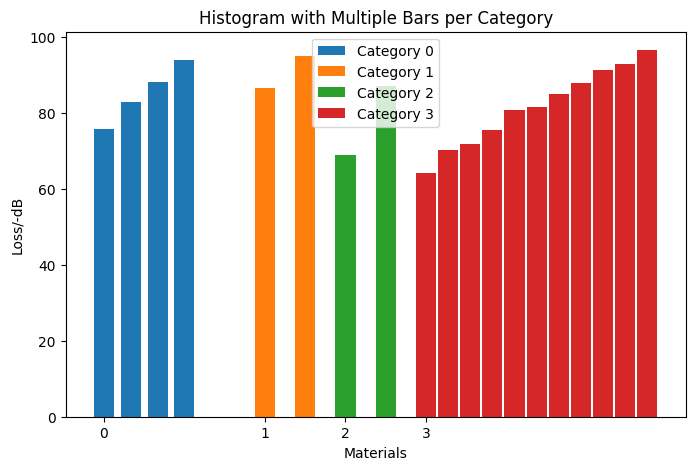

In [13]:
# and plot results
plt.figure()

# 输入数据
categories = paths.objects.numpy().squeeze()[0]
values = 10 * np.log10(np.abs(paths.a.numpy().squeeze())**2)
print(categories)
print(values)

# 找到唯一类别
unique_categories = np.unique(categories)

# 为每个类别分组数据
grouped_values = {cat: np.sort(-values[categories == cat]) for cat in unique_categories}
print(grouped_values)

# 计算柱状图的位置
bar_width = 0.2  # 每个柱子的宽度
x_positions = np.arange(len(unique_categories))  # 每个类别的 x 位置
print(x_positions)
spacing = 0.3  # 类别之间的间隔，增大此值可以使柱子之间有更多间隔

# 颜色列表（可选）
colors = ['r', 'g', 'b']

# 创建绘图
plt.figure(figsize=(8, 5))

lengths = np.insert([len(arr) for arr in grouped_values.values()], 0, 0)
spf = np.cumsum(lengths)

# 遍历类别，绘制柱状图
for i, (cat, vals) in enumerate(grouped_values.items()):
    # 为每个类别绘制多个柱子，确保它们在不同的 x 位置
    # np.linspace() 控制每个柱子在 x 轴上的具体位置，保证它们分开显示
    plt.bar(np.linspace(0, bar_width * vals.size, len(vals)) + spf[i] * bar_width * 2, 
            vals, width = bar_width, label = f'Category {cat}')

# 调整坐标轴
plt.xticks(spf[:len(grouped_values.values())] * bar_width * 2, [str(cat) for cat in unique_categories])  
plt.legend()
plt.xlabel("Materials")
plt.ylabel("Loss/-dB")
plt.title("Histogram with Multiple Bars per Category")

plt.show()